# Linear Regression

In [122]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [123]:
TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

In [124]:
# List of original numerical columns
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

# Apply log transformation and rename columns with "_log"
df_log = df[numerical_columns].apply(lambda x: np.log1p(x)).add_suffix('_log')

# Concatenate the log-transformed columns with the original DataFrame
df = pd.concat([df, df_log], axis=1)

# Display the DataFrame to confirm new columns
print(df.head())

# List of log-transformed numerical columns
numerical_columns_log = [col + '_log' for col in numerical_columns]

# Display summary statistics for log-transformed columns
print(df[numerical_columns_log].describe())

   number_of_seasons  number_of_episodes  vote_count  vote_average  \
0           0.033333            0.003503    1.000000        0.8442   
1           0.012500            0.001967    0.816031        0.8257   
2           0.016667            0.001632    0.739397        0.8624   
3           0.045833            0.008494    0.706044        0.8121   
4           0.025000            0.004463    0.634579        0.8486   

                                            overview  adult  popularity  \
0  Seven noble families fight for control of the ...    0.0    0.292397   
1  To carry out the biggest heist in history, a m...    0.0    0.025992   
2  When a young boy vanishes, a small town uncove...    0.0    0.050097   
3  Sheriff's deputy Rick Grimes awakens from a co...    0.0    0.132114   
4  Bored and unhappy as the Lord of Hell, Lucifer...    0.0    0.112400   

   episode_run_time                                   cleaned_overview  \
0          0.000000  seven noble family fight control 

In [125]:
drop_columns = {'popularity', 'cleaned_overview', 'overview'}

In [126]:
# Creating our labeled examples with 'y' as our label and 'X' being our features
y = df['popularity']
X = df.drop(columns = drop_columns, axis = 1)

In [127]:
X.columns.tolist()

['number_of_seasons',
 'number_of_episodes',
 'vote_count',
 'vote_average',
 'adult',
 'episode_run_time',
 'Action & Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'History',
 'Kids',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality',
 'Romance',
 'Sci-Fi & Fantasy',
 'Soap',
 'Talk',
 'War & Politics',
 'Western',
 'original-language_en',
 'original-language_zh',
 'original-language_ja',
 'original-language_ko',
 'original-language_de',
 'original-language_fr',
 'original-language_es',
 'original-language_pt',
 'original-language_ru',
 'original-language_nl',
 'created-by_Shotaro Ishinomori',
 'created-by_John de Mol',
 'created-by_Adrián Suar',
 'created-by_Simon Fuller',
 'created-by_Ekta Kapoor',
 'created-by_Na Young-seok',
 'created-by_Yang Li-Hua',
 'created-by_Joseph Barbera, William Hanna',
 'created-by_R.J. Nuevas',
 'created-by_Mark Burnett',
 'networks_BBC One',
 'networks_YouTube',
 'networks_Netflix',
 'networks_ITV1',
 'network

In [128]:
# Fill missing values in one-hot encoded columns with -1 or 'Unknown'
X.fillna(-1, inplace=True)  # or use 'Unknown'

We use train_test_split() because we want to split our data into training and test sets.

Train tests are used for fitting the model which means we train our model with this dataset.

Test sets are used to accurately evalute our final model's predicitions.

In [129]:
# Creating the training and test sets out of the labeled examples
# 30% of our data is for the test size, this will be the data used to test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1234)

In [130]:
# pd.set_option('display.max_columns', None)
# print(X_train.isnull().sum())

null_columns = X_train.columns[X_train.isnull().any()]
for col in null_columns:
    print(col)

In [131]:
bool_columns = X_train.select_dtypes(include=['bool'])
print(bool_columns.columns)

Index(['type_Documentary', 'type_Miniseries', 'type_News', 'type_Reality',
       'type_Scripted', 'type_Talk Show', 'type_Video', 'status_Canceled',
       'status_Ended', 'status_In Production', 'status_Pilot',
       'status_Planned', 'status_Returning Series', 'first_air_date_winter',
       'first_air_date_spring', 'first_air_date_summer', 'first_air_date_fall',
       'last_air_date_winter', 'last_air_date_spring', 'last_air_date_summer',
       'last_air_date_fall'],
      dtype='object')


Linear Regression

In [132]:
print(X.dtypes)

for col in df.columns:
    print(f"Column: {col}, Type: {df[col].dtype}")

number_of_seasons         float64
number_of_episodes        float64
vote_count                float64
vote_average              float64
adult                     float64
                           ...   
number_of_episodes_log    float64
vote_count_log            float64
vote_average_log          float64
popularity_log            float64
episode_run_time_log      float64
Length: 103, dtype: object
Column: number_of_seasons, Type: float64
Column: number_of_episodes, Type: float64
Column: vote_count, Type: float64
Column: vote_average, Type: float64
Column: overview, Type: object
Column: adult, Type: float64
Column: popularity, Type: float64
Column: episode_run_time, Type: float64
Column: cleaned_overview, Type: object
Column: Action & Adventure, Type: float64
Column: Animation, Type: float64
Column: Comedy, Type: float64
Column: Crime, Type: float64
Column: Documentary, Type: float64
Column: Drama, Type: float64
Column: Family, Type: float64
Column: History, Type: float64
Column: Kids, 

In [133]:
categorical_cols = X.select_dtypes(include=['object']).columns
print(categorical_cols)

Index([], dtype='object')


In [134]:
for column in X.columns:
    missing_count = X[column].isnull().sum()
    print(f"Column: {column}, Missing Values: {missing_count}")

Column: number_of_seasons, Missing Values: 0
Column: number_of_episodes, Missing Values: 0
Column: vote_count, Missing Values: 0
Column: vote_average, Missing Values: 0
Column: adult, Missing Values: 0
Column: episode_run_time, Missing Values: 0
Column: Action & Adventure, Missing Values: 0
Column: Animation, Missing Values: 0
Column: Comedy, Missing Values: 0
Column: Crime, Missing Values: 0
Column: Documentary, Missing Values: 0
Column: Drama, Missing Values: 0
Column: Family, Missing Values: 0
Column: History, Missing Values: 0
Column: Kids, Missing Values: 0
Column: Music, Missing Values: 0
Column: Musical, Missing Values: 0
Column: Mystery, Missing Values: 0
Column: News, Missing Values: 0
Column: Reality, Missing Values: 0
Column: Romance, Missing Values: 0
Column: Sci-Fi & Fantasy, Missing Values: 0
Column: Soap, Missing Values: 0
Column: Talk, Missing Values: 0
Column: War & Politics, Missing Values: 0
Column: Western, Missing Values: 0
Column: original-language_en, Missing Val

In [135]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

LinearRegression()

In [136]:
y_lr_pred = LR_model.predict(X_test)

In [137]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error, root_mean_squared_error

# Compute RMSE using the new function
LR_rmse = root_mean_squared_error(y_test, y_lr_pred)

LR_mse = mean_squared_error(y_test, y_lr_pred)

# Compute R² score
LR_r2 = r2_score(y_test, y_lr_pred)

# Compute MAE using the new function
LR_mae = mean_absolute_error(y_test, y_lr_pred)

# Print the results
print('Linear Regression: Root Mean Squared Error: {}'.format(LR_rmse))
print('Linear Regression: R^2: {}'.format(LR_r2))
print('Linear Regression: Mean Absolute Error: {}'.format(LR_mae))
print('Linear Regression: Mean Squared Error: {}'.format(LR_mse))

print('done')

Linear Regression: Root Mean Squared Error: 0.0010693496873491032
Linear Regression: R^2: 0.9924667085682582
Linear Regression: Mean Absolute Error: 0.00024071823213712705
Linear Regression: Mean Squared Error: 1.1435087538336249e-06
done


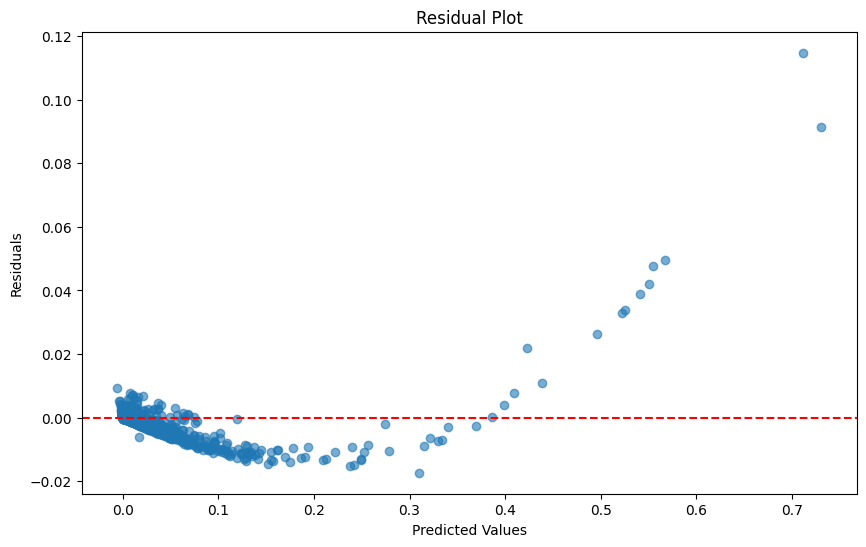

In [138]:
# https://how2matplotlib.com/how-to-create-a-residual-plot-in-python.html
residuals = y_test - y_lr_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_lr_pred, residuals, alpha=0.6)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()